In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
#from keras import  backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

2024-03-09 03:46:50.818852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 03:46:50.819010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 03:46:50.986438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits 
X_test = test.values.astype('float32')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 
#expand 1 more dimention as 1 for colour channel gray (3 dimention)
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape


(28000, 28, 28, 1)

In [7]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 
#calculate means for X_train
mean_px = X_train.mean().astype(np.float32)
#calculate std for X_train
std_px = X_train.std().astype(np.float32)

#standardize input data
def standardize(x):
    return (x-mean_px)/std_px

In [8]:
#Step 1 :  (Data Preprocessing/Feature Extraction) -- Lambda 
#Step 2 :  Classification --Conv2D,MaxPooling2D,Flatten,Dense
#Step 8 :  Ensemble -- Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

# Define your standardize function somewhere above this code.
# It should take an input tensor and return a standardized tensor,
# typically by subtracting the mean and dividing by the standard deviation.

model = Sequential([
    Input(shape=(28, 28, 1)),  # Input layer
    Lambda(standardize),  # Make sure `standardize` is defined
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(axis=1),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    BatchNormalization(axis=1),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Last layer has 10 units for 10 classes
])

In [9]:
#Step 2 :  Classification -- categorical_crossentropy 
#Step 3 :  Regression -- accuracy 

from tensorflow.keras.optimizers import RMSprop

#optimizer=RMSprop(lr=0.001): RMSprop is an optimization algorithm
#loss='categorical_crossentropy': This specifies the loss function to use during training. 
#metrics=['accuracy']: This parameter defines the evaluation metric(s) to be used during training,In this case, it's set to 'accuracy', 
#which computes the accuracy of the model's predictions compared to the true labels. (high level model performance)

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
#Step 1 :  (Data Preprocessing/Feature Extraction) --one-hot
#Step 2 :  Classification -- one-hot

#convert train data to ont-hot format
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train)


In [11]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 

#split datd to train/val
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [12]:
X_train.shape

(37800, 28, 28, 1)

In [13]:
#Step 1 :  (Data Preprocessing/Feature Extraction) 

#purpose generate more data for AI training.
#ImageDataGenerator: This class is used for generating batches of augmented data.
#batches: This is a generator object that yields batches of augmented data. specifies the batch size (64 in this case).

gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [14]:
#Step 2 :  Classification -- model 
#Step 3 :  Regression -- model .fit()

#By using fit_generator, the model will train using the data generated by the specified generators (batches for training and val_batches for validation)
# history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=50,
history=model.fit(x=batches, steps_per_epoch=batches.n, epochs=50,
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  591/37800 ━━━━━━━━━━━━━━━━━━━━ 1:38:01 158ms/step - accuracy: 0.8243 - loss: 0.7697

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


37800/37800 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - accuracy: 0.9194 - loss: 0.2984 - val_accuracy: 0.9745 - val_loss: 0.0772
Epoch 2/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - accuracy: 0.9746 - loss: 0.0890 - val_accuracy: 0.9781 - val_loss: 0.0718
Epoch 3/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.9802 - loss: 0.0691 - val_accuracy: 0.9795 - val_loss: 0.0822
Epoch 4/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - accuracy: 0.9832 - loss: 0.0597 - val_accuracy: 0.9855 - val_loss: 0.0573
Epoch 5/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9833 - loss: 0.0584 - val_accuracy: 0.9898 - val_loss: 0.0373
Epoch 6/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9854 - loss: 0.0500 - val_accuracy: 0.9874 - val_loss: 0.0416
Epoch 7/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - accuracy: 0.9866 - loss: 0.0489 - val_accuracy: 0.9869 - val_loss: 0.0502
Epoch 8/50
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.986

In [15]:
history.history.keys()
#expected dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

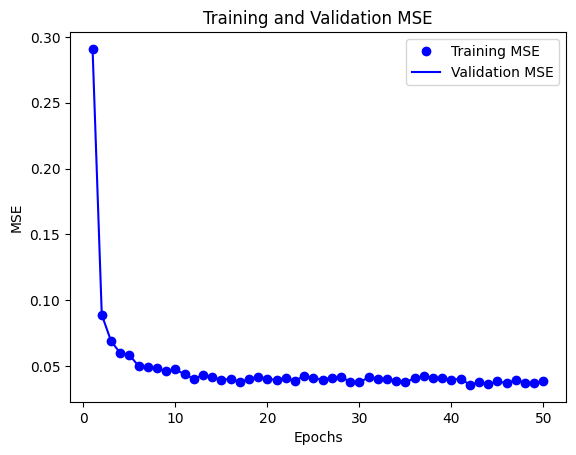

In [16]:
#Step 1 :  (Data Preprocessing/Feature Extraction) -- history 
#Step 2 :  Classification -- loss,val_loss 
#Step 3 :  Regression -- loss,val_loss   
#Step 4 :  Dimensionality Reduction -- epochs   

import matplotlib.pyplot as plt

# visualize the Mean Squared Error (MSE) values during training and validation epochs
# Assuming 'history' is the result from the fit function
# And it contains 'mse' as a metric. If it's not the case, replace 'mse' and 'val_mse' with 'accuracy' and 'val_accuracy'

mse = history.history['loss']
val_mse = history.history['loss']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()


In [17]:
#Step 2 :  Classification -- model.predict 
#Step 4 :  Ensemble -- np.argmax(prediction, axis=-1)   

#making predictions using a trained Keras model 
prediction=model.predict(X_test,verbose=0) # verbose = 0 , means not print any intermediate information
predictions = np.argmax(prediction, axis=-1) # Setting axis=-1 means that the maximum value is computed along the last axis of the array
pred=pd.Series(predictions)
submission=pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label']=pred
submission.to_csv("submission.csv",index=False)